<a href="https://colab.research.google.com/github/tlysenko/ML-notebooks/blob/master/Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing and installing the libraries

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install shap

In [ ]:
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import shap

import tensorflow as tf

import numpy as np
import pandas as pd


import catboost
from catboost import CatBoostClassifier


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


## Neural Network model

### Load and split the data

In [ ]:
data = load_breast_cancer()

In [ ]:
y = data['target']
X = data['data']

print(y.shape, X.shape)

(569,) (569, 30)


In [ ]:
# NAN values 
np.isnan(X).sum(), np.isnan(y).sum()

(0, 0)

#### Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9999, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(455, 30) (114, 30) (455,) (114,)


In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)

(57, 30) (57, 30) (57,) (57,)


#### Target variable distribution


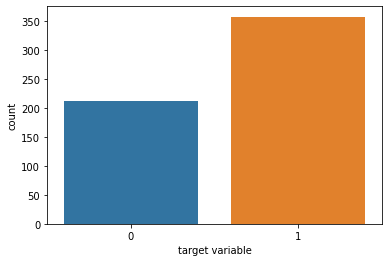

In [ ]:
# Target variable distribution is balanced 

ax = sns.countplot(x = y);
ax.set(xlabel='target variable', ylabel='count');

#### Scale the data

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
N, D = X_train.shape 
print(N,D)

455 30


### Building and training basic NN

In [ ]:
model1 = tf.keras.Sequential([
                              tf.keras.layers.Input(shape=(D,)),
                              tf.keras.layers.Dense(units = 1,
                                                    activation='sigmoid')
                            ])

model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics = ['accuracy'])

In [ ]:
model1.fit(x = X_train,
           y = y_train,
           epochs = 1000, 
           verbose = 0,
           validation_data = (X_val, y_val),
         
)

### Model evaluation

In [ ]:
prediction_nn = model1.predict(X_test)
prediction_nn = [np.round(x,0) for x in prediction_nn]

confusion_matrix(y_test, prediction_nn)

array([[20,  1],
       [ 3, 33]])

In [ ]:
print(classification_report(y_test, prediction_nn))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.97      0.92      0.94        36

    accuracy                           0.93        57
   macro avg       0.92      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57



## Catboost model


### Load and split the data

In [ ]:
data = load_breast_cancer()

y = data['target']
X = data['data']

print(y.shape, X.shape)

(569,) (569, 30)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9999, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(455, 30) (114, 30) (455,) (114,)


### Building and training the model

In [ ]:
catb_clf = CatBoostClassifier(objective = 'Logloss')

In [ ]:
catb_clf.fit(X_train, y_train)

### Model evaluation

In [ ]:
prediction_cb = catb_clf.predict(X_test)


confusion_matrix(y_test, prediction_cb)

array([[41,  1],
       [ 1, 71]])

In [ ]:
print(classification_report(y_test, prediction_cb))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### Feature importance with Catboost

In [ ]:
df_x = pd.DataFrame(data = data['data'], columns=data.feature_names)

explainer = shap.TreeExplainer(catb_clf)
shap_values = explainer.shap_values(df_x)

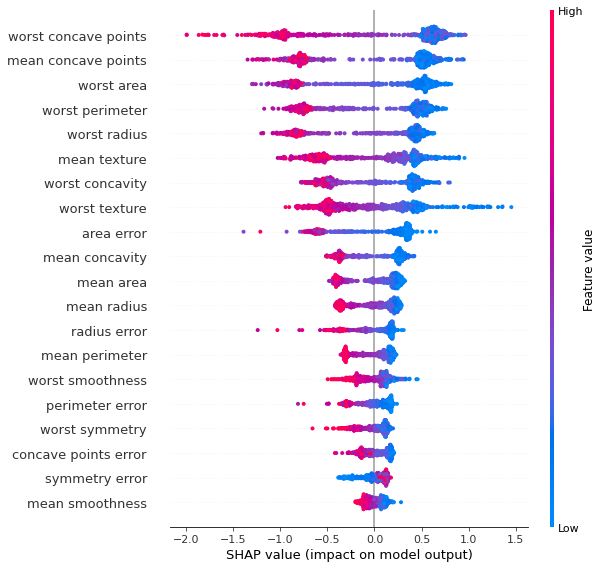

In [ ]:
shap.initjs()

shap.summary_plot(shap_values, df_x)

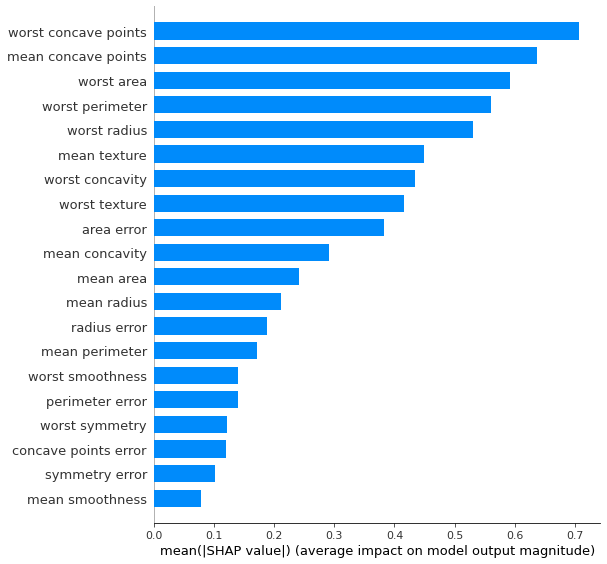

In [ ]:
shap.summary_plot(shap_values, features=df_x, feature_names=df_x.columns, plot_type='bar')